# Azimuth Pattern Calculator

Brian Hawkins, JPL 2023-09-22

This notebook demonstrates how to check the azimuth antenna pattern from a SAR raw data file.  It assumes that the scene is bright and homogeneous with relatively little topographic variation, like you might see in a tropical forest.  With these assumptions, the azimuth spectrum is used to measure the azimuth antenna pattern.

This example uses an ALOS PALSAR scene collected over the Amazon. The focused image is shown below.

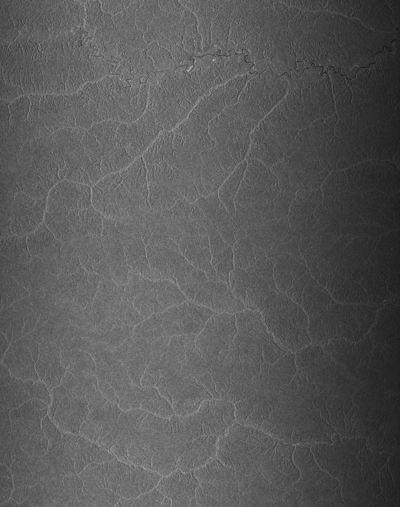

In [1]:
import numpy as np
import matplotlib.pyplot as p
import scipy
from tqdm.notebook import tqdm
import isce3
import nisar

## Inputs

In [2]:
l0b_filename = "ALPSRP075277050-H1.0__A.h5"
subband, pol = "A", "HH"
coherent_processing_interval = 1.0  # seconds
dem = isce3.geometry.DEMInterpolator()
num_average_range = 100
# EL bounds (in radians) for averaging azimuth pattern.
# Either can be None to default to measured extrema.
el_clip_min, el_clip_max = None, None

## Azimuth Spectrum

In [3]:
reader = nisar.products.readers.Raw.open_rrsd(l0b_filename)
pulse_times, grid = reader.getRadarGrid(subband)
dset = reader.getRawDataset(subband, pol)
m, n = dset.shape
print("raw data shape =", dset.shape)

raw data shape = (35118, 5194)


In [4]:
fc, fs, K, T = reader.getChirpParameters(subband, pol[0])
tbp = abs(K * T * T)
print(f"will average {num_average_range} samples while chirp length is {round(T * fs)}")

will average 100 samples while chirp length is 432


In [5]:
nfft = scipy.fft.next_fast_len(round(coherent_processing_interval * grid.prf))
skip = nfft // 2
window = np.hanning(nfft)
print("azimuth FFT size =", nfft)

azimuth FFT size = 2156


In [6]:
azspec = np.zeros((nfft, n))
dc = 0.0j
for i in tqdm(range(0, m - nfft, skip)):
    zi = window[:,None] * dset[i:i+nfft, :]
    dc += np.mean(zi[1:] * zi[:-1].conj())
    Zi = scipy.fft.fft(zi, axis=0)
    azspec += np.abs(Zi)**2

# Estimate scalar Doppler centroid using all available data.
fdc = np.angle(dc) * grid.prf / (2 * np.pi)
print(f"Doppler centroid (Hz) = {fdc:.1f}")

# Calculate spectral frequencies and wrap them to +/- PRF/2 around the centroid.
fd = np.fft.fftfreq(nfft, d=1/grid.prf)
fd = (fd - fdc + grid.prf / 2) % grid.prf + fdc - grid.prf / 2

# Reorder frequency axis so it's monotonic.
i = np.argsort(fd)
azspec = azspec[i,:]
fd = fd[i]

  0%|          | 0/31 [00:00<?, ?it/s]

Doppler centroid (Hz) = 74.7


normalizing by 99.0 percentile value 5734850.792375237


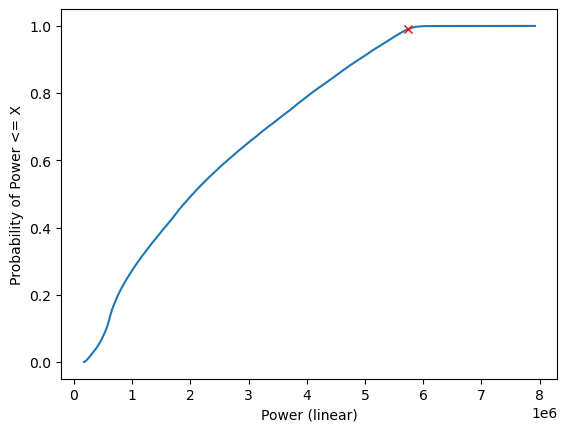

In [7]:
# Do some averaging in range
navg = n // num_average_range
range_avg = np.array(grid.slant_ranges)[:navg * num_average_range].reshape((navg, num_average_range)).mean(axis=-1)
azspec_avg = azspec[:, :navg * num_average_range].reshape((nfft, navg, num_average_range)).mean(axis=-1)

# Try to normalize max to unity while ignoring spurious peaks.
azspec_avg_sort = np.sort(azspec_avg.flat)
cdf = np.arange(len(azspec_avg_sort)) / len(azspec_avg_sort)
percentile_norm = 0.99
norm = azspec_avg_sort[round(percentile_norm * len(azspec_avg_sort))]
print(f"normalizing by {percentile_norm * 100} percentile value {norm}")
azspec_avg /= norm

p.plot(azspec_avg_sort, cdf)
p.plot(norm, percentile_norm, "xr")
p.xlabel("Power (linear)")
p.ylabel("Probability of Power <= X");

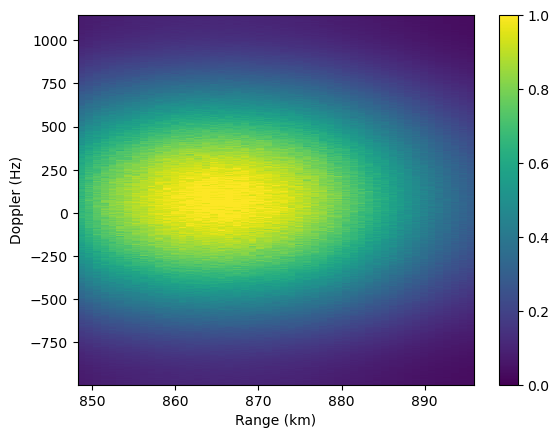

In [8]:
p.pcolormesh(range_avg / 1000, fd, azspec_avg, vmin=0, vmax=1)
p.xlabel("Range (km)")
p.ylabel("Doppler (Hz)")
p.colorbar();

Below we plot a slice through the peak of the beam.  This should already resemble the azimuth antenna pattern, but we'll take a few more steps to reduce noise and change coordinates.

range centroid (km) = 869.3589808213547
doppler centroid (Hz) = 74.24516177580159


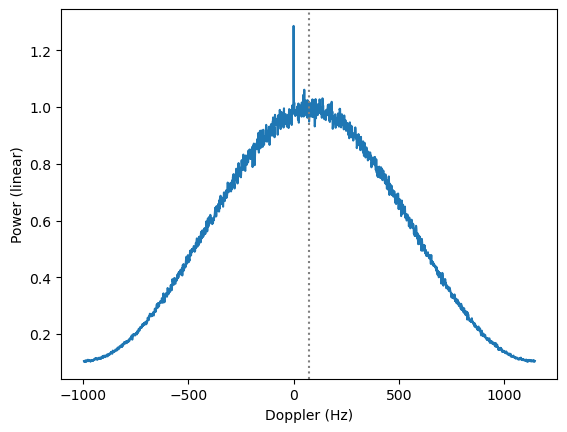

In [9]:
cm_range = np.sum(range_avg[None,:] * azspec_avg) / np.sum(azspec_avg)
cm_doppler = np.sum(fd[:,None] * azspec_avg) / np.sum(azspec_avg)
print("range centroid (km) =", cm_range / 1000)
print("doppler centroid (Hz) =", cm_doppler)

icm = np.argmin(abs(fd - cm_doppler))
jcm = np.argmin(abs(range_avg - cm_range))
p.plot(fd, azspec_avg[:,jcm])
p.axvline(cm_doppler, linestyle=":", color="gray")
p.xlabel("Doppler (Hz)")
p.ylabel("Power (linear)");

## Antenna Coordinates

Now we'll compute the mapping from radar range-Doppler coordinates to antenna angle coordinates.  For most SAR systems they are well aligned.  We will resample to an EL & AZ grid to ease comparison with our antenna pattern data.

In [10]:
el = np.zeros((nfft, navg))
az = np.zeros((nfft, navg))

orbit = reader.getOrbit()
attitude = reader.getAttitude()
t = pulse_times[m // 2]
ell = isce3.core.Ellipsoid()
frame = isce3.antenna.Frame("EL_AND_AZ")

q_ecf2rcs = attitude.interpolate(t).conjugate()
radar_xyz, _ = orbit.interpolate(t)

for i in tqdm(range(nfft)):
    for j in range(navg):
        llh = isce3.geometry.rdr2geo(t, range_avg[j], orbit, grid.lookside, fd[i], grid.wavelength, dem)
        target_xyz = ell.lon_lat_to_xyz(llh)
        lookvec_ecf = target_xyz - radar_xyz
        lookvec_ecf *= 1 / np.linalg.norm(lookvec_ecf)
        lookvec_rcs = q_ecf2rcs.rotate(lookvec_ecf)
        el[i,j], az[i,j] = frame.cart2sph(lookvec_rcs)

  0%|          | 0/2156 [00:00<?, ?it/s]

In [11]:
print(f"EL min (deg) = {np.rad2deg(el.min()):+.3f}")
print(f"EL max (deg) = {np.rad2deg(el.max()):+.3f}")
print(f"AZ min (deg) = {np.rad2deg(az.min()):+.3f}")
print(f"AZ max (deg) = {np.rad2deg(az.max()):+.3f}")

EL min (deg) = -1.761
EL max (deg) = +2.066
AZ min (deg) = -0.979
AZ max (deg) = +0.929


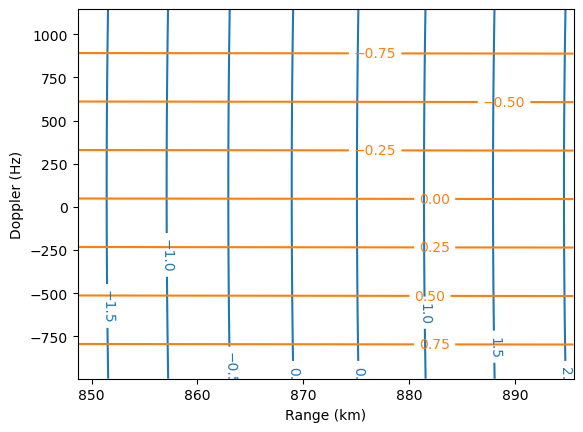

In [12]:
fig, ax = p.subplots()
cs_el = p.contour(range_avg / 1000, fd, np.rad2deg(el), colors="tab:blue", linestyles="solid")
cs_az = p.contour(range_avg / 1000, fd, np.rad2deg(az), colors="tab:orange", linestyles="solid")
ax.clabel(cs_el)
ax.clabel(cs_az)
p.xlabel("Range (km)")
p.ylabel("Doppler (Hz)");

In [13]:
# Resample to uniform AZ & EL grid.
# Using the overall min/max would lead to NaNs at the edges.
# Instead figure out largest inscribed rectangle, assuming a roughly affine mapping.
fudge = 0.95
if el_clip_min is None:
    el_clip_min = el[:,0].max() * fudge
if el_clip_max is None:
    el_clip_max = el[:,-1].min() * fudge
eli = np.linspace(el_clip_min, el_clip_max, navg)
azi = np.linspace(az[0,:].min(), az[-1,:].max(), nfft) * fudge

azspec_rcs = scipy.interpolate.griddata(
    (el.flat, az.flat),
    azspec_avg.flat,
    (eli[None,:], azi[:,None]),
    method="cubic",
    fill_value=0.0)

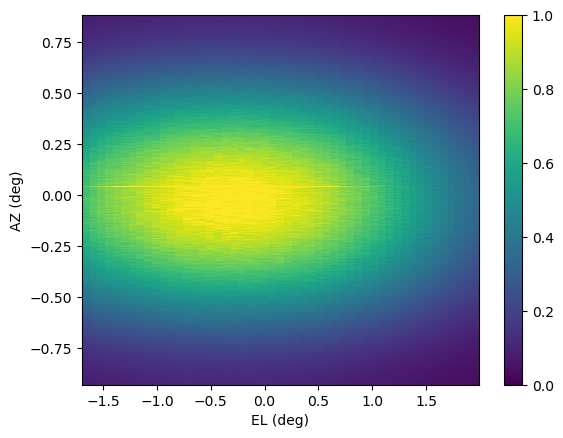

In [14]:
eli_deg = np.rad2deg(eli)
azi_deg = np.rad2deg(azi)

p.pcolormesh(eli_deg, azi_deg, azspec_rcs, vmin=0, vmax=1)
p.xlabel("EL (deg)")
p.ylabel("AZ (deg)")
#p.ylim(-.3, .3)
p.colorbar();

## Rank-One Approximation

Combining azimuth pattern estimates from multiple ranges is complicated by the modulation from the elevation pattern, range fading, incidence angle, etc.  We'll therefore estimate both the azimuth pattern and the range modulation terms using the separable approximation $f(AZ,EL) = u(AZ) \cdot v(EL)$.  We can compute this using the singular value decomposition (SVD) and taking the vectors associated with the largest singular value.  The ratio of the largest SV to the rest indicates the quality of the separable approximation.

CPU times: user 273 ms, sys: 18.7 ms, total: 291 ms
Wall time: 292 ms


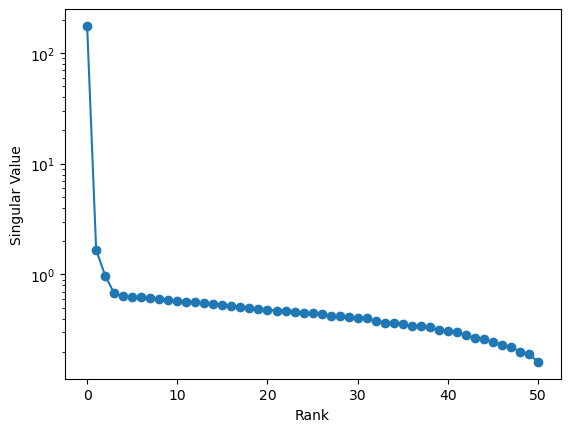

In [15]:
%%time
u, s, vh = np.linalg.svd(azspec_rcs)

# careful of sign and scaling
azpat = abs(u[:,0]) * abs(s[0] * vh[0,:]).max()
elpat = abs(vh[0,:]) * abs(s[0] * u[:,0]).max()

p.semilogy(s, 'o-')
p.xlabel("Rank")
p.ylabel("Singular Value");

We'll also plot the residual between the measured spectra and the rank-1 approximation.  It shoud just look like measurement noise.

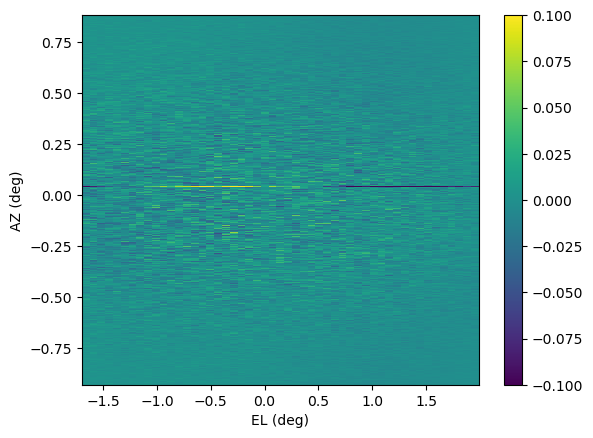

In [16]:
azspec_rcs_rank1 = np.outer(u[:,0], s[0] * vh[0,:])
p.pcolormesh(eli_deg, azi_deg, azspec_rcs - azspec_rcs_rank1, vmin=-0.1, vmax=0.1)
p.xlabel("EL (deg)")
p.ylabel("AZ (deg)")
p.colorbar();

## Range Modulation Terms

These are all the nuisance terms in range that we took out.

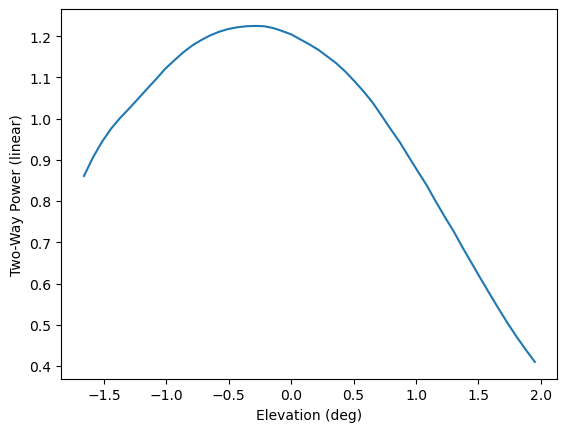

In [17]:
p.plot(eli_deg, elpat)
p.xlabel("Elevation (deg)")
p.ylabel("Two-Way Power (linear)");

## Estimated Azimuth Pattern

Now we'll show the estimated azimuth pattern and compute its centroid and width in the angle domain.

AZ centroid (deg) = -0.024
Half power beam width (deg) = 1.367


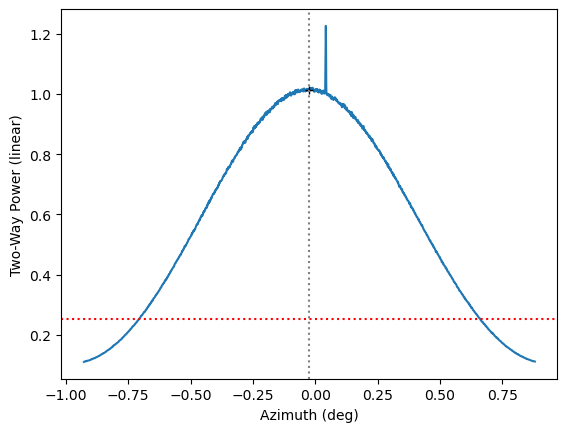

In [18]:
cm_az_deg = np.sum(azpat * azi_deg) / np.sum(azpat)
print(f"AZ centroid (deg) = {cm_az_deg:.3f}")

# Figure out one-way half power beam width.
# We have two-way power, so use 0.25 as cutoff.
idx_az_cm = np.argmin(abs(azi_deg - cm_az_deg))
peak = azpat[idx_az_cm]
k = np.where(azpat > 0.25 * peak)[0]
# Order of AZ axis is swapped for left/right looking, so take abs()
hpbw = abs(azi_deg[k[0]] - azi_deg[k[-1]])
print(f"Half power beam width (deg) = {hpbw:.3f}")

p.plot(azi_deg, azpat)
p.plot(azi_deg[idx_az_cm], azpat[idx_az_cm], "+k")
p.axvline(cm_az_deg, linestyle=":", color="gray")
p.axhline(0.25 * peak, linestyle=":", color="red")
p.xlabel("Azimuth (deg)")
p.ylabel("Two-Way Power (linear)");